# Fokker-Planck Equation III: Operator Splitting

This notebook investigates operator splitting methods for the Fokker Planck equation. Thus far in the notebook series, we have investigated the two terms in the FPE (Advection and Diffusion) separately, and in this notebook, we will investigate how these independent term-wise solutions can be used in combination to integrate the entire advection-diffusion equation, and discuss why it works, as well as the motivations and runtime savings afforded to the full implementation as a result.

We can write the 1D Fokker-Planck equation, in general, as 

$$ \partial_t p(x, t) = \partial_x[\mu(x, t) p(x, t)] + D \partial_{xx}^2 p(x, t) $$

Which, can be written more concisely in terms of the differential operator $\mathcal{L}$ (often referred to as the *generator*) as

$$ \partial_t p(x, t) = \mathcal{L} \cdot p(x, t) $$

where the Fokker-Planck operator $\mathcal{L}$ is defined as

$$ \mathcal{L} \equiv \left( \partial_x \mu(x, t) + D\partial_{xx}^2 \right) $$

Formally, the solution for $p(x, t)$ of the operator equation is simple (given an initial distribution $p(x, t_0)$), and simply written as

$$ p(x, t) = e^{\mathcal{L} \Delta t} p(x, t_0) $$

however, in practice, this solution is defined only in terms of its Taylor series, and is virtually impossible to evaluate in practice. However, if you consider the limit where only a small amount of time has passed ($\Delta t \ll 1$) then the exponential can be well approximted with its linear-order Taylor series as

$$ p(x, t) \approx p(x, t_0) + \Delta t \mathcal{L}\cdot p(x, t_0) $$

which formally aprpoximates the actual FPE in the $\Delta t \to 0$ limit, as we can re-arrange this equation to read

$$ \frac{p(x, t) - p(x, t_0)}{\Delta t} \approx \partial_t p(x, t) = \mathcal{L}p(x, t_0)$$

So, what does this get us? Well, first, for finite but small timesteps, this equation gives an approximate means of iteratively updating the initial probability (essentialy what we are doing with the advection and diffusion terms in isolation). However, there is a set of methods (bradly known as *operator splitting* methods) that can significantly simplify the calculation of this in practice.

Before delving into how operator splitting works in practice, its worth brining attantion to our prior analysis of the integration schemes for advection and diffusion alone. For the advective equation, the Lax-Wendroff method was sufficient to give high levels of stability, but gets complicated and cumbersome to apply to higher order equations like those involving diffusion. Conversely, a primary consideration for improving wall clock times in the diffusion equation was the fact that we were able to (often) make the simplification to the diffusion update that the coefficient $D$ was constant, and thus we were only required to invert the Crank-Nicolson matrices onces, and then use that inverse going forward (which provided a significant speedup---that improves with increasing $N$---upon inverting a matrix in each iteration). For many dynamic problems (virtually all instances of the Soluchowski equation that we will be interested in) the dynamics enter through the advective term, then it would be nice to still retain the ability to use the constant-$D$ speedup.  Herein lies the benefit of operator splitting methods.  Note that we can generally write the full Fokker-Planck equation as a summation over the advective $\mathcal{L}_{\rm A}$ and diffusive $\mathcal{L}_{\rm D}$ terms, and so the formal solution can be written as

$$ p(x, t) = e^{\mathcal{L}_{\rm A} + \mathcal{L}_{\rm D}}p(x, t_0) $$

Now, if the operators were themselves represented as simple numbers, then we would be able to split up the action of the operator on the initial probability into two contributions explicitlty and treat the operation of each term independently of the others. However, this is (unfortunately) not the case, and so such a procedure will not be correct.

More specifically, we can make an appeal to an important result in the field of Lie algebras---known as the Baker-Campbell-Hausdorff (BCH) formula---to better understand what is going on. For our purposes, the BCH formla states that, for two operators $X$ and $Y$, the followign identity holds

$$ e^Xe^Y = e^Z $$

where

$$ Z \equiv X + Y + \frac{1}{2}[X, Y] - \frac{1}{12}[X, [X, Y]] - \frac{1}{12}[Y, [X, Y]] \cdots $$

where $[X, Y] \equiv XY - YX$ is the commutator beween $X$ and $Y$.

Now, in the context of the present problem, the BCH formula implies that the operator equation solving the Fokker Planck equation can be written as

$$ e^{(\mathcal{L}_{rm A} + \mathcal{L}_{\rm D})\Delta t + \frac{1}{2}[\mathcal{L}_{\rm A}, \mathcal{L}_{\rm D}]\Delta t^2 + \cdots} = e^{\mathcal{L}_{\rm A}\Delta t}e^{\mathcal{L}_{\rm D}\Delta t} $$

which implies that, to linear order in $\Delta t$, the simple decomposition of the composite operator $\mathcal{L}_{\rm A} + \mathcal{L}_{\rm D}$ into the product of individual contributions can accurately capture the same properties.  Formally, this process, which is known as *Lie splitting* breaks the update of the PDE into substeps. In practice, this approximation reduces the update of the composite equation into two sub-problems as

$$ p(x, t + \Delta t) \approx e^{\mathcal{L}_{\rm A}\Delta t} e^{\mathcal{L}_{\rm D}\Delta t}p(x, t) $$

is calculated by first applying the Diffusion update ($\exp(\mathcal{L}_{\rm D}\Delta t)$) and then the advection update ($\exp(\mathcal{L}_{\rm A}\Delta t)$) to the result. From a practical standpoint, this decomposition of integration updates into constituent pieces can be exceptionally convenient as it allows us to independently treat the advection and diffusion parts of the equation, potentially using different integration schemes for each.

While thie approach is convenient as-is, there are still some issues. Namely, there is an ambiguity as to which term to apply first. Given that the commutator between the advection and diffusion operators is assumed to be nonzero, the results will not be the same if the advection or diffusion operators are applied first (although, they will be up to $\Delta t$). Further, the Advection and Diffusion integration schemes we have build for each component are accurate to $\Delta t^2$, so using the Lie splitting scheme eliminates that accuracy, reducing it to $\Delta t$.

This problem can be resolved, however, by instead considering the following (seemingly trivial) modification of the original update operator:

$$ e^{(\mathcal{L}_{\rm A} + \mathcal{L}_{\rm D})\Delta t} = e^{\tfrac{1}{2}(\mathcal{L}_{\rm A} + \mathcal{L}_{\rm D})\Delta t}e^{\tfrac{1}{2}(\mathcal{L}_{\rm D} + \mathcal{L}_{\rm A})\Delta t} $$

which is exact, because an operator will commute with itself, by definition. Note that in the second term on the RHS, the order of the updates has been switched. Now, performing a Lie splitting on both terms from the RHS above gives

$$ e^{\tfrac{1}{2}(\mathcal{L}_{\rm A} + \mathcal{L}_{\rm D})\Delta t + \frac{1}{2}[\mathcal{L}_{\rm A}, \mathcal{L}_{\rm D}]\Delta t^2} = e^{\frac{1}{2}\mathcal{L}_{\rm A}\Delta t}e^{\frac{1}{2}\mathcal{L}_{\rm D}\Delta t} $$
$$ e^{\tfrac{1}{2}(\mathcal{L}_{\rm D} + \mathcal{L}_{\rm A})\Delta t - \frac{1}{2}[\mathcal{L}_{\rm A}, \mathcal{L}_{\rm D}]\Delta t^2} = e^{\frac{1}{2}\mathcal{L}_{\rm D}\Delta t}e^{\frac{1}{2}\mathcal{L}_{\rm A}\Delta t} $$

where in the second operator we have used the identity $[A, B] = -[B, A]$.  Here, it can be seen that, when we combine the two above updates, the $\mathcal{O}(\Delta t^2)$ error terms cancel out, leading to an update scheme that (much like our individual Advection and Diffusion schemes) is accurate to $\mathcal{O}(\Delta t^2)$. Here, the higher order $\Delta t^3$ errors enter through the commultation ov each individual operator with ts commutator (*i.e.* $[\mathcal{L}_{\rm A}, [\mathcal{L}_{\rm A}, \mathcal{L}_{\rm D}]]$). 

Putting this all together the resulting operator decomposition, which in this case is known as *Symmetric Strang Splitting*, is 

$$ p(x, t + \Delta t) \approx e^{-\frac{1}{2}\mathcal{L}_{\rm A}\Delta t}e^{\mathcal{L}_{\rm D}\Delta t} e^{\frac{1}{2}\mathcal{L}_{\rm A}\Delta t}p(x, t) $$

which corresponds to the sequential operations of a 1/2-timestep update of the probability with the advection dynamics, a full time-step update of the diffusive dynamics, followed by another half-step update of the advection dynamics.

Note here that there is still a slight asymmetry in this update equation. The order in which we apply the diffusion and advection updated is not equal. There is another scheme that seeks to remedy this, known as *Symmetrically Weighted Strang Splitting* (SWSS), which is implemented as an option in the integrator, and explained in more detail in Ref[1]

#### References

* [1] W. Press, S. Teukolsky, W. Vetterling, & B. Flannery, *Numerical Recipes: The Art of Scientific Computing*, 3rd Ed., 2007, Cambridge University Press.

In this notebook, we will shows that these splitting schemes do, in fact, succeed in reproducing the correct dynamics of the composite system. Given that we have thusfar developed integration schemes targetted for each term individually, rather than compare the split dynamics to a full integration of the composition (advection + diffusion), we will simply show that the integration split solutions reproduce the same physically relevant features of the dynamics that we would use to judge the efficacy of a full composite integrator.

In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fokker_planck.integrator import FokkerPlanck1D
import fokker_planck.forceFunctions as ff
from fokker_planck.types.basetypes import SplitMethod, BoundaryCondition

sns.set(style="darkgrid", palette="hls")


In [26]:
# Now we can instantiate an integrator
# Dynamics parameters
D = 1.0
dt = 0.01
dx = 0.01
x_array = np.arange(-1, 1, dx)

fpe = FokkerPlanck1D(D, dt, dx, x_array, split_method=SplitMethod.Lie)
fpe_split = FokkerPlanck1D(D, dt, dx, x_array, split_method=SplitMethod.Lie)


In [27]:
# Now we can initialize a Gaussian distribution in both scenarios, and show that a full integration step
# reproduces the same output as a manual splitting operation in all of the optional cases.
init_var = 0.05
init_mean = 0.0

fpe.initialize_probability(init_mean, init_var)
fpe_split.initialize_probability(init_mean, init_var)

init_prob = fpe.prob.copy()

In [28]:
# First, we start with a Lie splitting, which just integrates each substep in
# sequence
fpe.integrate_step(([1.0]), ff.constant_force)

fpe_split.advection_update(([1.0]), ff.constant_force, dt)
fpe_split.diffusion_update()

In [29]:

fpe_prob_lie = fpe.prob.copy()
fpe_prob_lie_split = fpe_split.prob.copy()

(fpe.prob == fpe_split.prob).all(), (fpe.prob == init_prob).all()


(True, False)

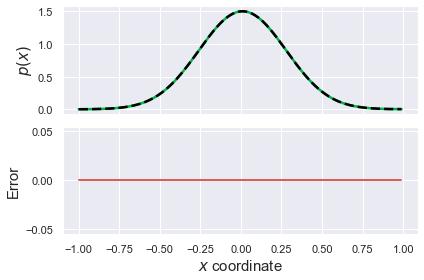

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(fpe.x_array, fpe_prob_lie, color=sns.xkcd_rgb["shamrock"], linewidth=2.5)
ax[0].plot(fpe_split.x_array, fpe_prob_lie_split, color='k', linestyle='--', linewidth=2.5)

ax[1].plot(fpe.x_array, fpe_prob_lie - fpe_prob_lie_split, linewidth=2.0)
ax[1].set_xlabel(r"$x$ coordinate", fontsize=15)
ax[1].set_ylabel(r"Error", fontsize=15)
ax[0].set_ylabel(r"$p(x)$", fontsize=15)
plt.tight_layout()

In [31]:
# Now, we can do the same analysis for the strang splitting scheme, which is slightly different.
# it preserves symmetry under time reversal, by splitting one of the integration steps into two
# substeps and puts them on either side of the other. Specifically, the Strang integration step
# is
# 0.5 * Advection -> Diffusion -> 0.5 * Advection
# This is out implementation, but the breaking-out of the advection step into
# the different subteps can also be done on the diffusion opeartor.

fpe.initialize_probability(init_mean, init_var)
fpe_split.initialize_probability(init_mean, init_var)

fpe.split_method = SplitMethod.Strang

# Strang splitting
fpe.integrate_step(([1.0]), ff.constant_force)

# Manual implementation
fpe_split.advection_update(([1.0]), ff.constant_force, 0.5 * fpe_split.dt)
fpe_split.diffusion_update()
fpe_split.advection_update(([1.0]), ff.constant_force, 0.5 * fpe_split.dt)

In [32]:
fpe_prob_strang = fpe.prob.copy()
fpe_prob_strang_split = fpe_split.prob.copy()

(fpe_prob_strang == fpe_prob_strang_split).all(), (fpe_prob_strang == init_prob).all()

(True, False)

Text(0, 0.5, 'Error')

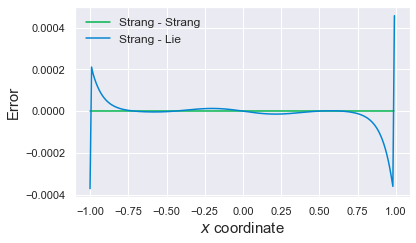

In [33]:
# Similarly, we can plot the difference between the two versions of the update
# but ALSO the differences between the Lie split and Strang split versions
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(fpe.x_array, fpe_prob_strang - fpe_prob_strang_split, label="Strang - Strang", color=sns.xkcd_rgb["shamrock"])
ax.plot(fpe.x_array, fpe_prob_strang - fpe_prob_lie, label="Strang - Lie", color=sns.xkcd_rgb["cerulean"])
ax.legend(fontsize=12, frameon=False)
ax.set_xlabel(r"$x$ coordinate", fontsize=15)
ax.set_ylabel(r"Error", fontsize=15)


Here, we can see that there is a difference in the output of Strang vs Lie split implementations of the integration step. Given that the Strang splitting has a higher order of accuracy in time, we should take its output to be more correct.

There is, however, a third splitting scheme currently supported known as the symmetrically-weighted strang splitting, which operated by averaging the output of two Lie split updated, with opposite orderings of the advection and diffusion operations. This SWSS scheme achieves the same order of accuracy as the strang splitting scheme.

In [34]:
fpe.initialize_probability(init_mean, init_var)
fpe_split.initialize_probability(init_mean, init_var)

fpe.split_method = SplitMethod.SymStrang

# Strang splitting
fpe.integrate_step(([1.0]), ff.constant_force)

# Manual implementation
fpe_split.advection_update(([1.0]), ff.constant_force, fpe_split.dt)
fpe_split.diffusion_update()
prob_1 = fpe_split.prob.copy()

fpe_split.prob = init_prob
fpe_split.diffusion_update()
fpe_split.advection_update(([1.0]), ff.constant_force, fpe_split.dt)
prob_2 = fpe_split.prob.copy()

fpe_split.prob = 0.5 * (prob_1 + prob_2)

In [35]:
fpe_prob_swss = fpe.prob.copy()
fpe_prob_swss_split = fpe_split.prob.copy()

(fpe_prob_swss == fpe_prob_swss_split).all(), (fpe_prob_swss == init_prob).all()

(True, False)

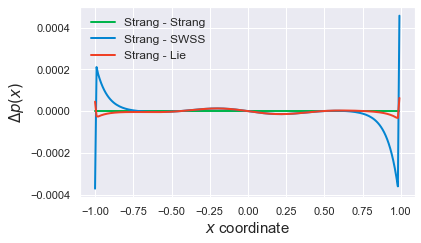

In [36]:
# And now we can compare the differences in all three splitting schemes
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(fpe.x_array, fpe_prob_strang - fpe_prob_strang_split, linewidth=2.0, color=sns.xkcd_rgb["shamrock"], label="Strang - Strang")
ax.plot(fpe.x_array, fpe_prob_strang - fpe_prob_lie, linewidth=2.0, color=sns.xkcd_rgb["cerulean"], label="Strang - SWSS")
ax.plot(fpe.x_array, fpe_prob_strang - fpe_prob_swss, linewidth=2.0, color=sns.xkcd_rgb["tomato"], label="Strang - Lie")

ax.legend(fontsize=12, frameon=False)
ax.set_xlabel(r"$x$ coordinate", fontsize=15)
ax.set_ylabel(r"$\Delta p(x)$", fontsize=15)
plt.show()